In [ ]:
# Description: Plot Figure 9 (Time-averaged Reynolds stress profiles for events in Figures 7 and 8).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import open_dataset
from cmocean.cm import balance
from pandas import Timestamp

In [3]:
def nrmsd(x, y):
    x, y = np.array(x), np.array(y)
    rmsd = np.sqrt(np.sum((x - y)**2)/y.size)
    return rmsd/y.ptp()

In [4]:
plt.close('all')

head = "../../data_reproduce_figs/"
fname = 'OC40S-Ad2rs5-10min_ensembles-nobinmap-bias-corrected.nc'

rho = 1024 # [kg/m3]

In [5]:
zlo, zhi = 0, 30
tln, trn = Timestamp('2017-10-15 00:00:00'), Timestamp('2017-10-18 12:00:00') # Persistent northward flow (OC40S depl 2)
tls, trs = Timestamp('2017-10-21 06:00:00'), Timestamp('2017-10-22 14:00:00') # Persistent southward flow (OC40S depl 2)

ds = open_dataset(head+fname)
ds = ds.sel(dict(z=slice(zlo, zhi)))
dsn = ds.sel(dict(t=slice(tln, trn)))
dss = ds.sel(dict(t=slice(tls, trs)))

tbores1 = dict(t=slice(Timestamp("2017-10-15 00:00:00"), Timestamp("2017-10-15 12:00:00")))
tbores2 = dict(t=slice(Timestamp("2017-10-16 00:00:00"), Timestamp("2017-10-16 12:00:00")))
tbores3 = dict(t=slice(Timestamp("2017-10-17 00:00:00"), Timestamp("2017-10-17 12:00:00")))
tbores4 = dict(t=slice(Timestamp("2017-10-18 00:00:00"), Timestamp("2017-10-18 12:00:00")))
tshearsouth = dict(t=slice(Timestamp("2017-10-22 01:00:00"), Timestamp("2017-10-22 11:00:00")))

uw_boresn = (dsn.sel(tbores1)['uw'].mean('t').values + dsn.sel(tbores2)['uw'].mean('t').values + dsn.sel(tbores3)['uw'].mean('t').values + dsn.sel(tbores4)['uw'].mean('t').values)/4
vw_boresn = (dsn.sel(tbores1)['vw'].mean('t').values + dsn.sel(tbores2)['vw'].mean('t').values + dsn.sel(tbores3)['vw'].mean('t').values + dsn.sel(tbores4)['vw'].mean('t').values)/4
uw_sshear = dss.sel(tshearsouth)['uw'].mean('t').values
vw_sshear = dss.sel(tshearsouth)['vw'].mean('t').values

In [6]:
# Calculate scaling factors based on time span of the conditional averages.
dtbores1 = tbores1['t'].stop - tbores1['t'].start
dtbores2 = tbores2['t'].stop - tbores2['t'].start
dtbores3 = tbores3['t'].stop - tbores3['t'].start
dtbores4 = tbores4['t'].stop - tbores4['t'].start
scale_bores = (dtbores1 + dtbores2 + dtbores3 + dtbores4)/(trn - tln)
scale_sshear = (tshearsouth['t'].stop - tshearsouth['t'].start)/(trs - tls)

In [7]:
uwn_tot = dsn['uw'].mean('t')
uws_tot = dss['uw'].mean('t')
vwn_tot = dsn['vw'].mean('t')
vws_tot = dss['vw'].mean('t')

# Ratios.
Ruw_shear = uw_sshear*scale_sshear/uws_tot
Rvw_shear = vw_sshear*scale_sshear/vws_tot
Ruw_bores = uw_boresn*scale_bores/uwn_tot
Rvw_bores = vw_boresn*scale_bores/vwn_tot

# Correlation coefficient between the profiles.
r2_uwboresn = np.corrcoef(uw_boresn*scale_bores, uwn_tot)[0][1]**2
print("Bores <-> total uw r2 = %.2f"%r2_uwboresn)
r2_vwboresn = np.corrcoef(vw_boresn*scale_bores, vwn_tot)[0][1]**2
print("Bores <-> total vw r2 = %.2f"%r2_vwboresn)

r2_uwsshear = np.corrcoef(uw_sshear*scale_sshear, uws_tot)[0][1]**2
print("Sheared flow <-> total uw r2 = %.2f"%r2_uwsshear)
r2_vwsshear = np.corrcoef(vw_sshear*scale_sshear, vws_tot)[0][1]**2
print("Sheared flow <-> total vw r2 = %.2f"%r2_vwsshear)

nmrsd_uwboresn = nrmsd(uw_boresn*rho, uwn_tot*rho)
nmrsd_vwboresn = nrmsd(vw_boresn*rho, vwn_tot*rho)
nmrsd_uwsshear = nrmsd(uw_sshear*rho, uws_tot*rho)
nmrsd_vwsshear = nrmsd(vw_sshear*rho, vws_tot*rho)

Bores <-> total uw r2 = 0.99
Bores <-> total vw r2 = 0.95
Sheared flow <-> total uw r2 = 0.61
Sheared flow <-> total vw r2 = 0.17


Text(0.05, 0.85, '(b)')

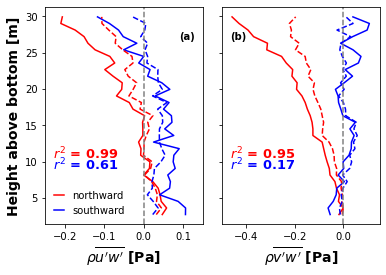

In [8]:
# Plotting.
z = ds['z'].values

fig, ax = plt.subplots(ncols=2, sharex=False, sharey=True)
ax1, ax2 = ax

ax1.plot(uwn_tot*rho, z, 'r-', label=r"northward")
ax1.plot(uws_tot*rho, z, 'b-', label=r"southward")
ax1.plot(uw_boresn*scale_bores*rho, z, 'r--')
ax1.plot(uw_sshear*scale_sshear*rho, z, 'b--')

ax2.plot(vwn_tot*rho, z, 'r-', label=r"northward")
ax2.plot(vws_tot*rho, z, 'b-', label=r"southward")
ax2.plot(vw_boresn*scale_bores*rho, z, 'r--')
ax2.plot(vw_sshear*scale_sshear*rho, z, 'b--')

ax1.text(0.05, 0.3, r"$r^2$ = %.2f"%r2_uwboresn, fontsize=13, color="r", fontweight='black', transform=ax1.transAxes)
ax2.text(0.05, 0.3, r"$r^2$ = %.2f"%r2_vwboresn, fontsize=13, color="r", fontweight='black', transform=ax2.transAxes)
ax1.text(0.05, 0.25, r"$r^2$ = %.2f"%r2_uwsshear, fontsize=13, color="b", fontweight='black', transform=ax1.transAxes)
ax2.text(0.05, 0.25, r"$r^2$ = %.2f"%r2_vwsshear, fontsize=13, color="b", fontweight='black', transform=ax2.transAxes)

ax1.axvline(color='gray', linestyle='dashed')
ax2.axvline(color='gray', linestyle='dashed')
ax1.legend(frameon=False, handlelength=1)

# ax1.set_xlim(-0.15, 0.15)
# ax2.set_xlim(-0.10, 0.10)
ax1.set_xlim(-0.25, 0.15)
ax2.set_xlim(-0.50, 0.15)

ax1.set_ylabel(r"Height above bottom [m]", fontsize=14, fontweight='black')
ax1.set_xlabel(r"$\rho\overline{u'w'}$ [Pa]", fontsize=14, fontweight='black')
ax2.set_xlabel(r"$\rho\overline{v'w'}$ [Pa]", fontsize=14, fontweight='black')
fig.subplots_adjust(wspace=0.12)

xt, yt = 0.85, 0.85
ax1.text(xt, yt, r"(a)", fontweight='black', transform=ax1.transAxes)
xt, yt = 0.05, 0.85
ax2.text(xt, yt, r"(b)", fontweight='black', transform=ax2.transAxes)

In [9]:
fig.savefig("fig09.png", dpi=300, bbox_inches="tight")
plt.show()